## **Project details**

`The goal of this project is to conduct a market basket analysis using the apriori algorithm. The data used is the Online Retail Data Set from UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/online+retail), and it is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.`



### **Market Basket Analysis**

`Market Basket Analysis is a data mining technique used to uncover associations and patterns within a set of transactions or customer purchases. It helps identify which items are frequently bought together or sequentially by customers. The analysis aims to understand the relationships between different products and uncover insights that can be used for various purposes, such as optimizing product placement, cross-selling, and targeted marketing.`

`By applying market basket analysis, we aim to uncover hidden patterns, associations, and co-occurrence of items within the transaction data. This will enable us to generate meaningful and actionable insights to support decision-making processes and enhance business strategies`

### **Dataset Description**

`The Online Retail Data Set contains a wealth of information about customer transactions. It includes details such as the invoice date and invoice no. of the transaction, the items purchased, the quantity, and the customer's ID. The dataset allows us to explore the purchasing patterns of customers and identify the relationships between different products.`

`All the necessary data cleaning and transformations are done to prepare the data for market basket analysis using the apriori algorithm.`

#### Necessary imports

In [1]:
#necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori,association_rules

#### Import data

In [2]:
#download data from UCI Machine Learning Repository
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx

--2023-05-19 19:18:10--  https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23715344 (23M) [application/x-httpd-php]
Saving to: ‘Online Retail.xlsx.2’

Online Retail.xlsx. 100%[===================>]  22.62M  56.1MB/s    in 0.4s    

2023-05-19 19:18:10 (56.1 MB/s) - ‘Online Retail.xlsx.2’ saved [23715344/23715344]



In [3]:
#read data
retail=pd.read_excel('/content/Online Retail.xlsx')
data=retail.copy()

#### Eda

`The objective of conducting Exploratory Data Analysis (EDA) is to gain familiarity with the dataset, extract valuable insights, and identify relevant patterns and trends that can contribute to achieving our project goal`

In [4]:
#data shape
data.shape

(541909, 8)

In [5]:
#data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
#check first five rows
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
#check nulls
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
#drop null
data.dropna(inplace=True)

In [9]:
#check duplicates
data.duplicated().sum()

5225

In [10]:
#Drop duplicates
data.drop_duplicates(inplace=True)

`since the dataset is large enough, missing values and duplicates were dropped `

In [11]:
#remove cancelled transactions
#convert invoiceNo to str
data['InvoiceNo']=data['InvoiceNo'].astype('str')
#extract values without cancelled transactions
data=data[~(data['InvoiceNo'].str.contains('c',case=False))]

`From observing the Stockcode column, it has values representing manual, postage,dot postage and some other charges, since these values clearly do not represents items, the rows containing them will be dropped`

In [12]:
#make stockcode list
stock_code_list=list(data['StockCode'])

#define function to get stockcodes without numbers
def get_stock_codes_without_numbers(stock_codes):
    result = []
    for code in stock_codes:
        code_str = str(code)
        if not any(char.isdigit() for char in code_str):
            result.append(code)
    return result

stock_codes_without_numbers=get_stock_codes_without_numbers(stock_code_list)
stock_codes_without_numbers=set(stock_codes_without_numbers)
print('Other non-item stockcodes:', stock_codes_without_numbers)

Other non-item stockcodes: {'DOT', 'BANK CHARGES', 'POST', 'PADS', 'M'}


In [13]:
#Exclude rows with stockcodes without numbers from the data
for stockcode in stock_codes_without_numbers:
  data=data[~(data['StockCode']==stockcode)]

In [14]:
#check number of unique customer
print('Number of Unique Customer_id -',data['CustomerID'].nunique())
#check number of unique items
print('Number of Unique items -', data['Description'].nunique())

Number of Unique Customer_id - 4335
Number of Unique items - 3872


In [15]:
#summary stats
data.describe()

,Quantity,UnitPrice,CustomerID
count,391316.000000,391316.000000,391316.000000
mean,13.175528,2.890193,15294.841072
std,181.876625,4.375175,1710.167127
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15157.000000
75%,12.000000,3.750000,16794.000000
max,80995.000000,649.500000,18287.000000


`The lowest unit price of an item is 0, since an item cannot have 0 price, the rows with this values will be dropped.`

In [16]:
#removing rows where UnitPrice=0 
data=data[~(data['UnitPrice']==0)]

In [17]:
#compare unique stockcode with description (one unique stockcode for unique item)
print('Number of unique stockcode :',data.StockCode.nunique())
print('Number of unique item description :',data.Description.nunique())

Number of unique stockcode : 3660
Number of unique item description : 3872


`the numbers of unique stock code and unique item description are different, and this ought not to be so, since there is one unique stockcode for one unique item. hence, this will be resolved.`

In [18]:
#get items with more than 1 stock code
desc_code_unique=(data.groupby('Description').agg({'StockCode':'nunique'}))
description_extra_sc=desc_code_unique[desc_code_unique['StockCode']>1]
#get names of the items more than 1 stock code
description_extra_sc.index

Index(['COLOURING PENCILS BROWN TUBE', 'COLUMBIAN CANDLE RECTANGLE',
       'COLUMBIAN CANDLE ROUND', 'EAU DE NILE JEWELLED PHOTOFRAME',
       'FRENCH FLORAL CUSHION COVER ', 'FRENCH LATTICE CUSHION COVER ',
       'FROSTED WHITE BASE ', 'METAL SIGN,CUPCAKE SINGLE HOOK',
       'PAPER LANTERN 9 POINT SNOW STAR', 'PINK FAIRY CAKE CUSHION COVER',
       'PINK FLOCK GLASS CANDLEHOLDER', 'PINK FLOWERS RABBIT EASTER',
       'RETRO PLASTIC 70'S TRAY', 'RETRO PLASTIC DAISY TRAY',
       'RETRO PLASTIC POLKA TRAY', 'ROUND BLUE CLOCK WITH SUCKER',
       'SQUARE CHERRY BLOSSOM CABINET', 'STORAGE TIN VINTAGE LEAF',
       'WHITE BAMBOO RIBS LAMPSHADE'],
      dtype='object', name='Description')

In [19]:
#get index number of item descriptions with more than 1 stock code
desc_index_to_drop=data[data['Description'].isin(description_extra_sc.index)].index
#drop item descriptions with more than 1 stock code
data=data.drop(index=desc_index_to_drop)

In [20]:
#get stockcode with more than 1 item description
sc_desc_unique=(data.groupby('StockCode').agg({'Description':'nunique'}))
stockcode_extra_desc=sc_desc_unique[sc_desc_unique['Description']>1]
stockcode_extra_desc.sample(5,random_state=13)

,Description
StockCode,
23106,2
23306,2
22287,2
23231,3
23250,2


In [21]:
#get index number of stockcode with more than 1 item description
sc_index_to_drop=data[data['StockCode'].isin(stockcode_extra_desc.index)].index
#drop item descriptions with more than 1 stock code
data=data.drop(index=sc_index_to_drop)

In [22]:
#check unique stockcode and Unique description number
print('Number of unique stockcode :',data.StockCode.nunique())
print('Number of unique item description :',data.Description.nunique())

Number of unique stockcode : 3415
Number of unique item description : 3415


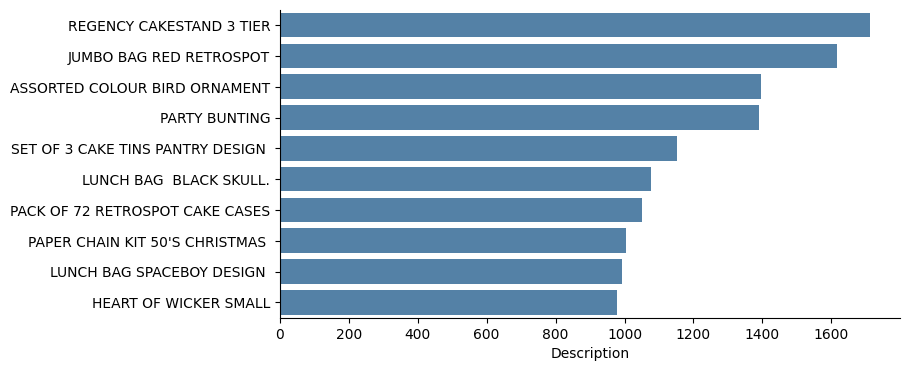

In [23]:
#Top items bought
top_10=data['Description'].value_counts(ascending=False)
top_10=top_10[0:10]
#plot barplot to show top 10 items bought
plt.figure(figsize=(8,4))
sns.barplot(data=data,y=top_10.index,x=top_10,color='steelblue',)
sns.despine()
plt.show()

`REGENCY CAKESTAND 3 TIER is the most bought item in the dataset.`

In [24]:
#Set InvoiceDate as index
data.set_index('InvoiceDate',inplace=True)

In [25]:
#dates with highest item purchase
highest_purchase_date=data.groupby('InvoiceDate')['Description'].count().sort_values(ascending=False)
print(highest_purchase_date[0:5])

InvoiceDate
2011-11-14 15:27:00    504
2011-11-28 15:54:00    496
2011-12-05 17:17:00    489
2011-10-31 14:09:00    406
2011-11-23 13:39:00    406
Name: Description, dtype: int64


`The day with highest items purchased is 2011-11-14`

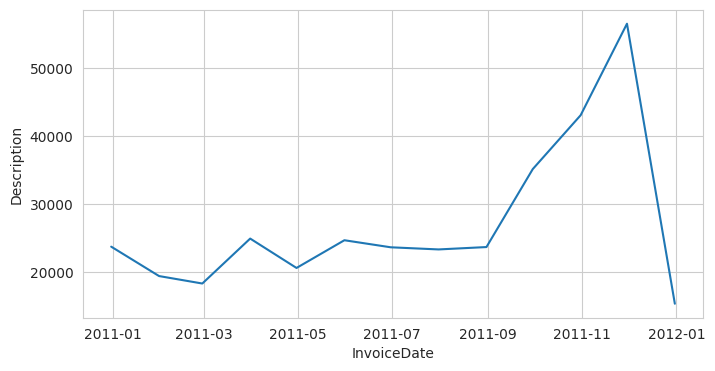

In [26]:
data_month=data.resample('M') 
data_month_count=data_month['Description'].count() 

#Plot of total number of items sold by month
plt.figure(figsize=(8,4))
sns.set_style('whitegrid')
sns.lineplot(data=data_month_count)
plt.show()

` November, 2011 was the month with highest items sold in the entire dataset.`

In [27]:
#Top 5 countries 
Top_5_countries=data.Country.value_counts().sort_values(ascending=False)
print(Top_5_countries[0:5])

United Kingdom    314039
Germany             7820
France              7297
EIRE                6531
Spain               2184
Name: Country, dtype: int64


`most of the purchase came from customers in the United Kingdom, followed by Germany and the rest.`

In [28]:
#Bottom 5 countries
low_5_countries=data.Country.value_counts().sort_values()
print(low_5_countries[0:5])

Saudi Arabia       9
Bahrain           17
Czech Republic    23
Brazil            32
Lithuania         35
Name: Country, dtype: int64


` The countries with customers with the lowest purchase are show above, with Saudi Arabi been the lowest. it could mean that we have few customers in those regions`

In [29]:
#Most expensive product
data.sort_values(by='UnitPrice',ascending=False).head(1)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,
2010-12-16 08:41:00,539080,22655,VINTAGE RED KITCHEN CABINET,1,295.0,16607.0,United Kingdom


` The Most expensive item in the dataset is the VINTAGE RED KITCHEN CABINET`

In [30]:
#total amount spent
data['TotalSpending']=data['Quantity']*data['UnitPrice']
#Top 5 customers
data.groupby('CustomerID')['TotalSpending'].sum().sort_values(ascending=False).iloc[0:5]

CustomerID
14646.0    247288.43
18102.0    233756.27
17450.0    173546.71
16446.0    168472.50
14911.0    126000.79
Name: TotalSpending, dtype: float64

` The customers with the overall highest total spending are shown above, with customerId-14646 being the customer with most spending.`

## **Market Basket Analysis Implementation**

#### Extract transactions from data



`Market basket analysis requires transactional data to be in a specific format, hence transactions are extracted from the cleaned data, and then these transaction list is represented in one hot encoding format.`

In [31]:
#extract transactions from data
transactions=[]
groups=list(data.groupby(['InvoiceDate','InvoiceNo'])['Description'])
for i in range(len(groups)):
    items=list(groups[i][1])
    transactions.append(items)

#### Onehot encoding transaction








In [32]:
#Onehot Encoding of transactions
te=TransactionEncoder()
data_ohe=te.fit_transform(transactions)

data_ohe=pd.DataFrame(data_ohe,columns=te.columns_)

In [33]:
#check encoded data
data_ohe.head(3)

,4 PURPLE FLOCK DINNER CANDLES,DOLLY GIRL BEAKER,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,SPACEBOY BABY GIFT SET,TRELLIS COAT RACK,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,...,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEART LATTICE TRAY OVAL,ZINC METAL HEART DECORATION,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#### Apriori algorithm

`The Apriori algorithm is a popular association rule mining algorithm used for discovering frequent itemsets in transactional datasets. It employs a breadth-first search strategy to identify itemsets that meet a minimum support threshold. The algorithm iteratively generates candidate itemsets and prunes those that are unlikely to be frequent based on the Apriori property. By iteratively applying this process, the algorithm efficiently finds frequent itemsets that can be used to generate meaningful association rules.`

In [34]:
#Frequent itemsets using apriori Algorithm
frequent_itemsets=apriori(data_ohe,min_support=0.01,use_colnames=True,max_len=4)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
print('Number of frequent itemsets -',len(frequent_itemsets))

Number of frequent itemsets - 841


#### Association Rule

`Association rule mining is a technique used to discover interesting relationships or patterns in large datasets. It identifies associations between items based on their co-occurrence in transactions. Association rules consist of an antecedent (premise) and a consequent (outcome) with corresponding measures like support, confidence, and lift.`

In [35]:
#Compute association rules with prunning
rules=association_rules(frequent_itemsets,metric='lift',min_threshold=1.01)
print('Number of Association rules -',len(rules))

Number of Association rules - 646


In [36]:
#check first 5 rows of association rules
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(PACK OF 72 RETROSPOT CAKE CASES),(60 CAKE CASES DOLLY GIRL DESIGN),0.056390,0.019399,0.010357,0.183673,9.468004,0.009263,1.201236
1,(60 CAKE CASES DOLLY GIRL DESIGN),(PACK OF 72 RETROSPOT CAKE CASES),0.019399,0.056390,0.010357,0.533898,9.468004,0.009263,2.024473
2,(72 SWEETHEART FAIRY CAKE CASES),(60 TEATIME FAIRY CAKE CASES),0.027455,0.036004,0.012111,0.441118,12.251928,0.011122,1.724864
3,(60 TEATIME FAIRY CAKE CASES),(72 SWEETHEART FAIRY CAKE CASES),0.036004,0.027455,0.012111,0.336377,12.251928,0.011122,1.465509
4,(60 TEATIME FAIRY CAKE CASES),(PACK OF 60 DINOSAUR CAKE CASES),0.036004,0.028989,0.012221,0.339422,11.708442,0.011177,1.469940


#### 1. What products are customers buying with HAND WARMER BIRD DESIGN?


In [37]:
targeted_rules=rules[rules['antecedents']=={'HAND WARMER BIRD DESIGN'}].copy()
filtered_rules=targeted_rules[(targeted_rules['lift']>1) &
                              (targeted_rules['confidence']>0.5) &
                              (targeted_rules['support']>0.01)].sort_values(by='confidence',ascending=False)
rules_data=filtered_rules[['antecedents','consequents','confidence']][0:3]

antecedents=rules_data['antecedents'].apply(lambda x: list(x)).astype("unicode").tolist()
consequents=rules_data['consequents'].apply(lambda x: list(x)).astype("unicode").tolist()
print('\n')
for i in rules_data['consequents']:
    print('People who buy HAND WARMER BIRD DESIGN','also buy', ((list(i))[0]))



People who buy HAND WARMER BIRD DESIGN also buy HAND WARMER OWL DESIGN
People who buy HAND WARMER BIRD DESIGN also buy HAND WARMER SCOTTY DOG DESIGN


#### 2. What products can be used to cross-sell POPPY'S PLAYHOUSE KITCHEN?



In [38]:
targeted_rules=rules[rules['consequents']=={"POPPY'S PLAYHOUSE KITCHEN"}].copy()
filtered_rules=targeted_rules[(targeted_rules['lift']>1) &
                              (targeted_rules['confidence']>0.75) &
                              (targeted_rules['support']>0.01)].sort_values(by='confidence',ascending=False)
rules_data=filtered_rules[['antecedents','consequents','confidence']][0:3]

antecedents=rules_data['antecedents'].apply(lambda x: list(x)).astype("unicode").tolist()
consequents=rules_data['consequents'].apply(lambda x: list(x)).astype("unicode").tolist()
print('\n')
for i in rules_data['antecedents']:
    print('People who buy', ((list(i))[0]),'also buy', "POPPY'S PLAYHOUSE KITCHEN")



People who buy POPPY'S PLAYHOUSE BEDROOM  also buy POPPY'S PLAYHOUSE KITCHEN
People who buy POPPY'S PLAYHOUSE LIVINGROOM  also buy POPPY'S PLAYHOUSE KITCHEN
People who buy POPPY'S PLAYHOUSE BEDROOM  also buy POPPY'S PLAYHOUSE KITCHEN


#### Recommendation system 


`A recommendation system for generating recommendation based on product's stockcode.The created function can be used by providing a valid stock code as an argument, and it will output relevant product recommendations based on the association rules derived from the dataset`

In [39]:
def get_recommendation(stockcode):
  #function to give product recommendation
  try:
    item_name=data[data['StockCode']==(stockcode)].loc[:,'Description'].unique()
    item_name=item_name[0]
  except:
    print("StockCode doesn't exist, Try again!")      #outcome if wrong stockcode is entered
  else:
    targeted_rules=rules[rules['antecedents']=={item_name}].copy()
    if len(targeted_rules)!=0:                                        # if stockcode's product is part of association rules

        filtered_rules=targeted_rules[(targeted_rules['lift']>1) &
                                  (targeted_rules['confidence']>0.5) &
                                  (targeted_rules['support']>0.01)].sort_values(by='confidence',ascending=False)
        rules_data=filtered_rules[['antecedents','consequents','confidence']][0:3]

        antecedents=rules_data['antecedents'].apply(lambda x: list(x)).astype("unicode").tolist()
        consequents=rules_data['consequents'].apply(lambda x: list(x)).astype("unicode").tolist()

        print('\n')
        for i in rules_data['consequents']:
            if len(rules_data['consequents']) != 0:
                print('People who buy', item_name,'also buy', ((list(i))[0]))
            else:
              print("No possible recommendation")             #outcome if stockcode's product consequents do not have confidence > 0.5 
    else:
      print("No possible recommendation")                     #outcome if stockcode's product is not part of association rules

In [40]:
#check recommendation
get_recommendation(21086)



People who buy SET/6 RED SPOTTY PAPER CUPS also buy SET/6 RED SPOTTY PAPER PLATES
People who buy SET/6 RED SPOTTY PAPER CUPS also buy SET/20 RED RETROSPOT PAPER NAPKINS 


In [43]:
from google.colab import files
downloaded=files.download('/content/drive/MyDrive/Data science projects/uci_online_retail_data_cleaned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>